In [1]:
import tensorflow as tf


class AttrDict(dict):
    __setattr__ = dict.__setitem__
    __getattr__ = dict.__getitem__


def plot_grid_ds(ds, model=None, size=(3, 3), figsize=(10, 10)):
    from copy import copy
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import ImageGrid

    n = size[0] * size[1]
    ds_ = copy(ds)

    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(
        fig,
        111,
        nrows_ncols=size,
        axes_pad=0.3,
    )
    for X_batch, y_batch in ds_.unbatch().shuffle(n).batch(n).take(1):
        y_hat_batch = model.predict(X_batch).argmax(axis=-1) if model else y_batch
        for X, y, y_hat, ax in zip(X_batch, y_batch, y_hat_batch, grid):
            title = (
                f"{ds.class_names[y]} (true) - {ds.class_names[y_hat]} (pred)"
                if model
                else f"{ds.class_names[y]}"
            )
            ax.set_title(title)
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
            ax.imshow(X / 255, cmap="gray")
    return grid


class BalancedSparseCategoricalAccuracy(tf.keras.metrics.SparseCategoricalAccuracy):
    def __init__(self, name="balanced_sparse_categorical_accuracy", dtype=None):
        super().__init__(name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_flat = y_true
        if y_true.shape.ndims == y_pred.shape.ndims:
            y_flat = tf.squeeze(y_flat, axis=[-1])
        y_true_int = tf.cast(y_flat, tf.int32)

        cls_counts = tf.math.bincount(y_true_int)
        cls_counts = tf.math.reciprocal_no_nan(tf.cast(cls_counts, self.dtype))
        weight = tf.gather(cls_counts, y_true_int)
        return super().update_state(y_true, y_pred, sample_weight=weight)


In [2]:
import tensorflow as tf



class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


class ViTClassfier(tf.keras.models.Model):
    CONFIG = {
        "patch_size": 8,
        "embedding_dim": 64,
        "n_heads": 3,
        "n_transformers": 1,
        "transformer_units": [128, 64],
        "transformer_dropout": 0.1,
        "mlp_units": [8192, 4096],
        "mlp_dropout": 0.1,
    }

    def __init__(self, input_shape, n_classes, config={}):
        super(ViTClassfier, self).__init__()

        self._config = AttrDict(
            **{
                **self.CONFIG,
                **config,
                "input_shape": input_shape,
                "n_classes": n_classes,
            }
        )
        self._construct_model()

    def call(self, x):
        return self._model(x)

    def _construct_model(self):
        config = self._config

        num_patches = (config.input_shape[0] // config.patch_size) ** 2

        inputs = tf.keras.layers.Input(shape=config.input_shape)

        patches = Patches(config.patch_size)(inputs)
        # Encode patches.
        encoded_patches = PatchEncoder(num_patches, config.embedding_dim)(patches)

        # Create multipletf.keras.layers of the Transformer block.
        for _ in range(config.n_transformers):
            # Layer normalization 1.
            x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
            # Create a multi-head attention layer.
            attention_output = tf.keras.layers.MultiHeadAttention(
                num_heads=config.n_heads, key_dim=config.embedding_dim, dropout=0.1
            )(x1, x1)
            # Skip connection 1.
            x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
            # Layer normalization 2.
            x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
            # MLP.
            for units in config.transformer_units:
                x3 = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(x3)
                x3 = tf.keras.layers.Dropout(config.transformer_dropout)(x3)

            # Skip connection 2.
            encoded_patches = tf.keras.layers.Add()([x3, x2])

        # Create a [batch_size, projection_dim] tensor.
        features = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        features = tf.keras.layers.Flatten()(features)
        features = tf.keras.layers.Dropout(0.5)(features)
        # Add MLP.
        for units in config.mlp_units:
            features = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(features)
            features = tf.keras.layers.Dropout(config.mlp_dropout)(features)
        # Classify outputs.
        logits = tf.keras.layers.Dense(config.n_classes)(features)
        # Create the Keras model.
        self._model = tf.keras.models.Model(inputs=inputs, outputs=logits)





In [3]:


import tensorflow as tf

### 1. Exploratory Data Analysis

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


path = Path("/content/drive/MyDrive/Colab Notebooks/Dataset_BUSI_with_GT")
img_as_jpg = list(path.glob(r"*/*.png"))

# Counts the number of each categories in the dataset
file_count = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],img_as_jpg))
benign = file_count.count('benign')
malignant = file_count.count('malignant')
normal = file_count.count('normal')


In [6]:
normal

266

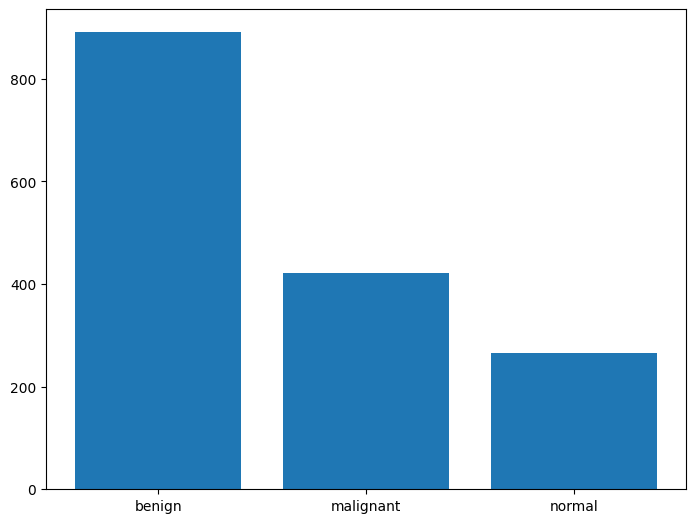

In [7]:
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
labels = ['benign','malignant', 'normal']
count_train = [benign,malignant,normal]
ax.bar(labels, count_train)
plt.show()

In [8]:
train = pd.concat([pd.Series(img_as_jpg,name="image").apply(str),pd.Series(file_count, name="type")],axis=1)
train = train.sample(frac=1).reset_index(drop=True)
print(np.shape(train))

(1578, 2)


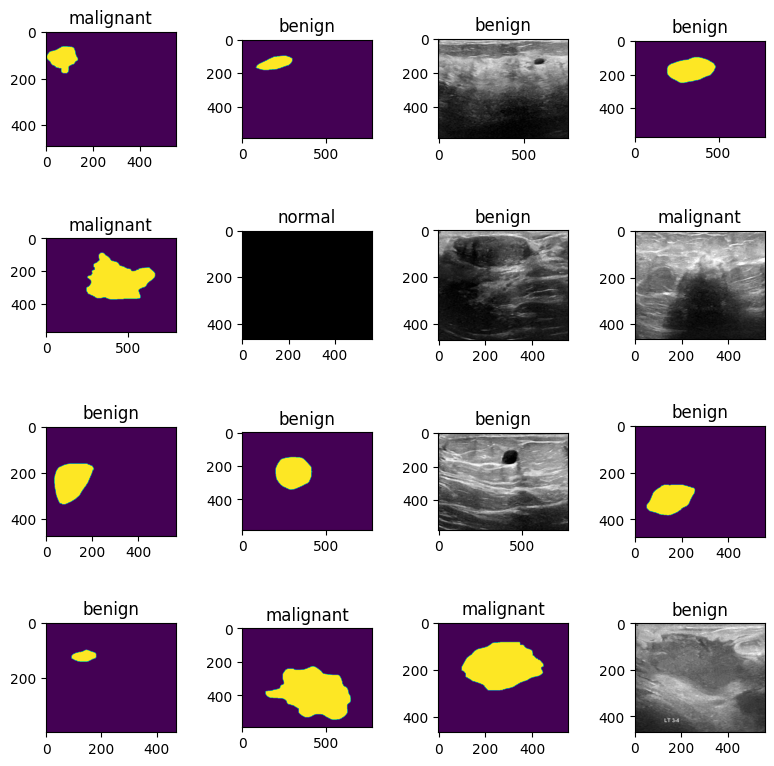

In [9]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout()
counter = 0
for ax in axes.reshape(-1):
    ax.imshow(plt.imread(train["image"][counter]))
    ax.set_title(train["type"][counter])
    plt.rcParams["axes.grid"] = False
    counter = counter+1

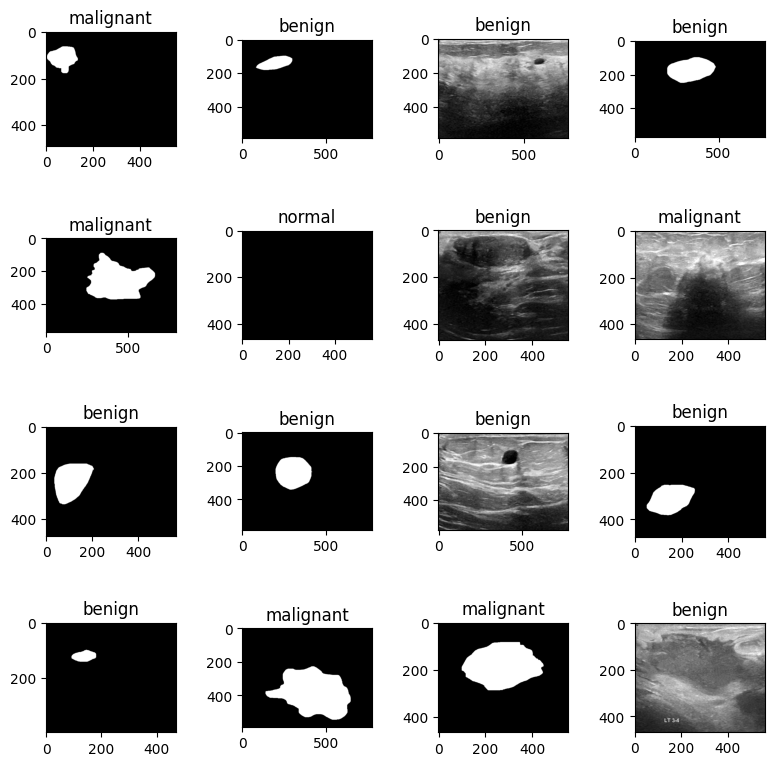

In [10]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout()
counter = 0
for ax in axes.reshape(-1):
  # Load image and convert to grayscale if necessary
  image = plt.imread(train["image"][counter])
  if len(image.shape) == 3 and image.shape[2] == 3:  # Check for RGB format
    image = tf.image.rgb_to_grayscale(image)  # Convert to grayscale using TensorFlow
  ax.imshow(image, cmap='gray')  # Display with grayscale colormap
  ax.set_title(train["type"][counter])
  plt.rcParams["axes.grid"] = False
  counter += 1


## 2. Model

In [11]:
hparams = AttrDict(
    image_size=(128,128, 3),
    n_classes=3,
    batch_size=64,
)

ds = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Colab Notebooks/Dataset_BUSI_with_GT", image_size=hparams.image_size[:-1], batch_size=hparams.batch_size)
train_split = round(0.8 * ds.cardinality().numpy())
train_ds = ds.take(train_split); train_ds.class_names = ds.class_names
validation_ds = ds.skip(train_split); validation_ds.class_names = ds.class_names

Found 1578 files belonging to 3 classes.


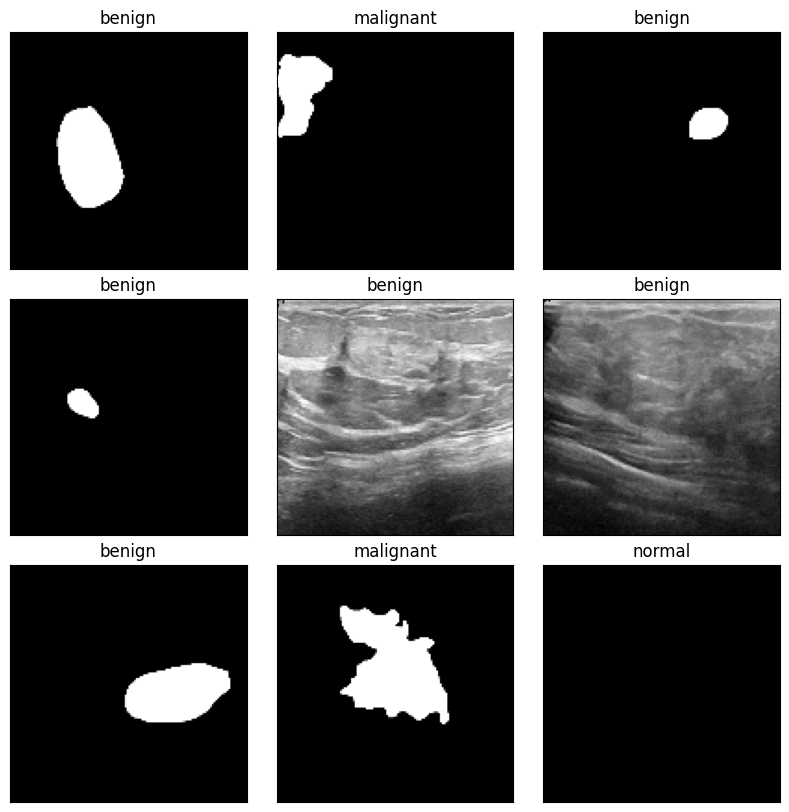

In [12]:
_ = plot_grid_ds(train_ds)

In [13]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = ViTClassfier(hparams.image_size, hparams.n_classes)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy", BalancedSparseCategoricalAccuracy()]
    )

Epoch 1/30
20/20 [==============================] - 90s 4s/step - loss: 30.9602 - accuracy: 0.4344 - balanced_sparse_categorical_accuracy: 0.3596 - val_loss: 1.5345 - val_accuracy: 0.3624 - val_balanced_sparse_categorical_accuracy: 0.3397
Epoch 2/30
20/20 [==============================] - 18s 779ms/step - loss: 1.0660 - accuracy: 0.5523 - balanced_sparse_categorical_accuracy: 0.4546 - val_loss: 0.8660 - val_accuracy: 0.6946 - val_balanced_sparse_categorical_accuracy: 0.5649
Epoch 3/30
20/20 [==============================] - 18s 788ms/step - loss: 0.8991 - accuracy: 0.5875 - balanced_sparse_categorical_accuracy: 0.4774 - val_loss: 1.2269 - val_accuracy: 0.5101 - val_balanced_sparse_categorical_accuracy: 0.3836
Epoch 4/30
20/20 [==============================] - 20s 874ms/step - loss: 0.9182 - accuracy: 0.5773 - balanced_sparse_categorical_accuracy: 0.4303 - val_loss: 0.9061 - val_accuracy: 0.5738 - val_balanced_sparse_categorical_accuracy: 0.4038
Epoch 5/30
20/20 [====================

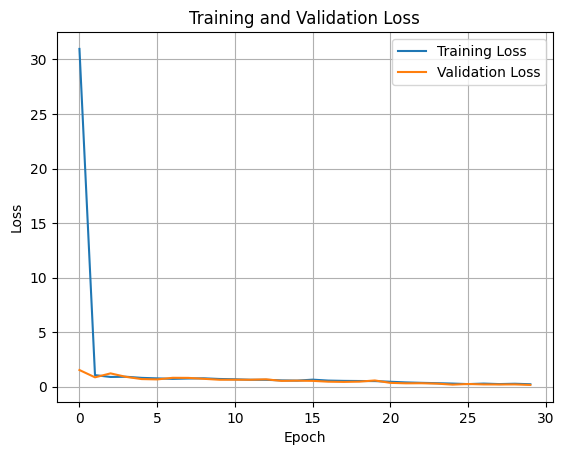

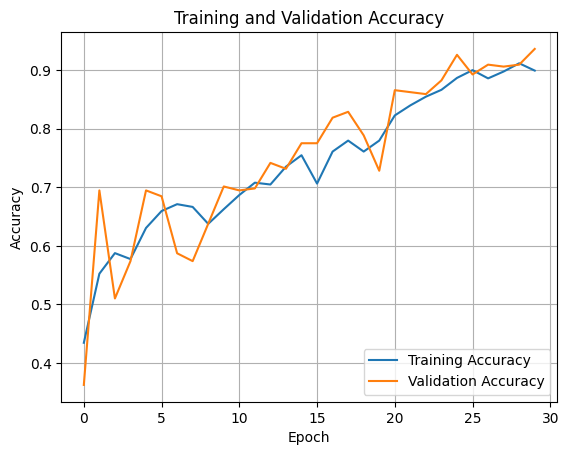

Final Training Accuracy: 89.92%
Final Validation Accuracy: 93.62%
Total time taken: 684.02 seconds
10/10 [==============================] - 1s 16ms/step


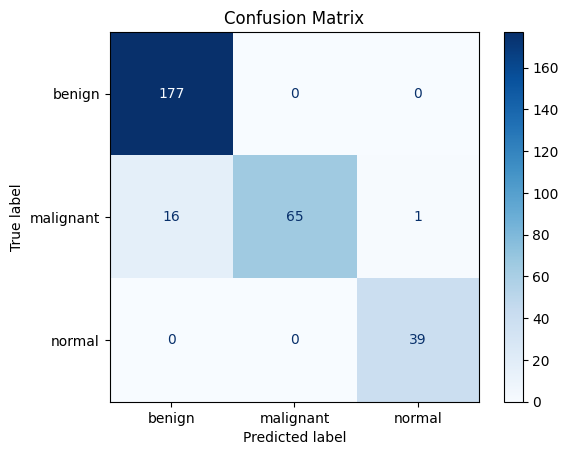


Class-wise Precision: [0.91709845 1.         0.975     ]

Class-wise Recall: [1.         0.79268293 1.        ]

Class-wise F1-score: [0.95675676 0.88435374 0.98734177]

Overall Accuracy: 94.30%

Macro Precision: 0.9640328151986184

Macro Recall: 0.9308943089430896

Macro F1-score: 0.942817423468418


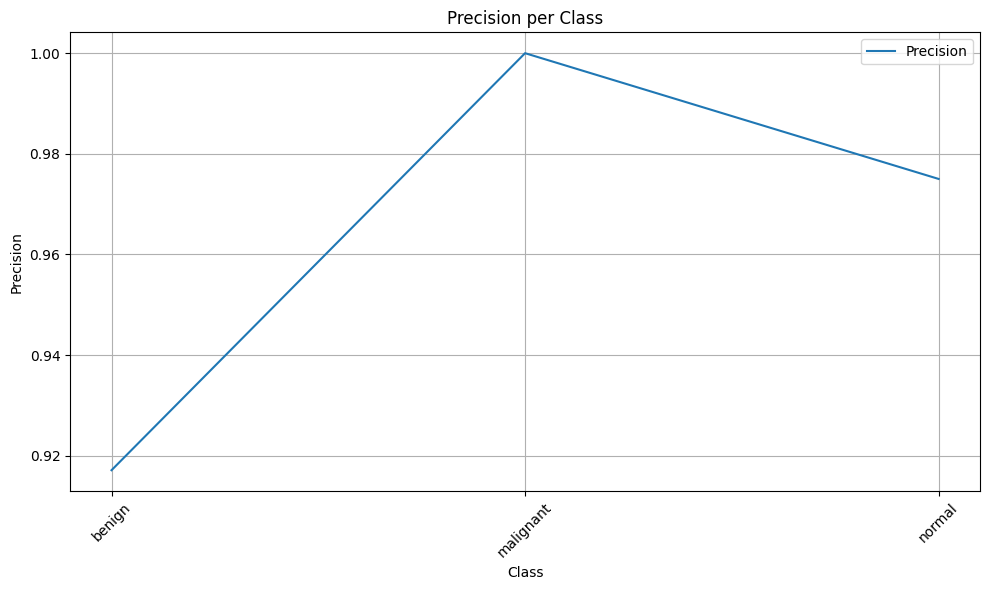

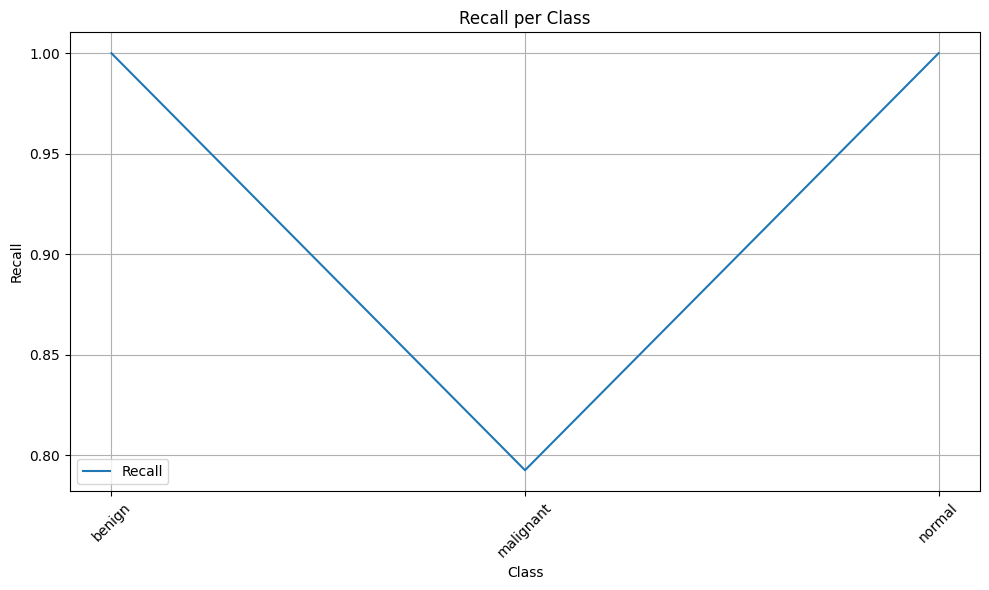

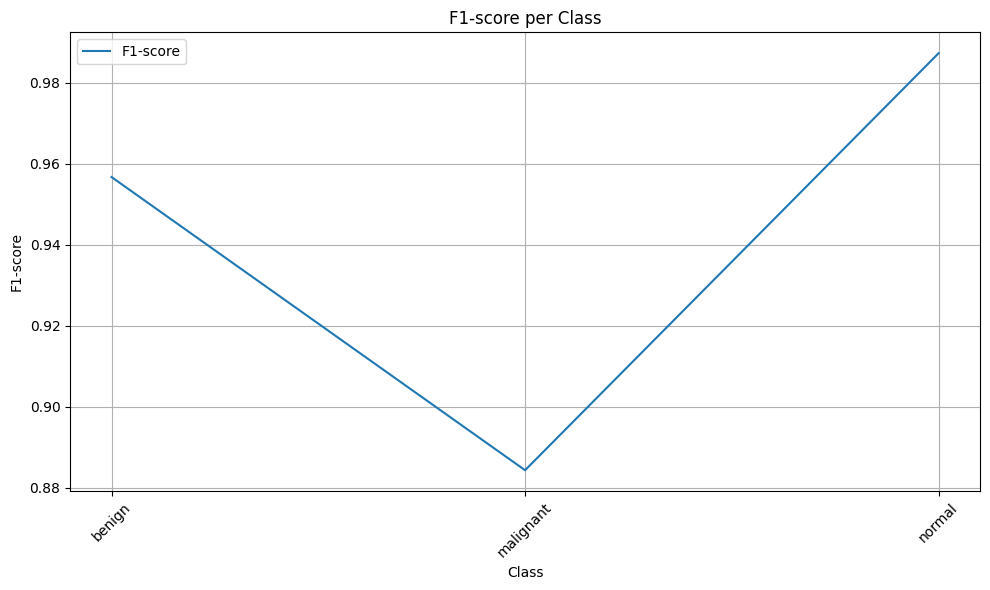

In [ ]:
import time
import tensorflow as tf
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

start = time.time()

# Configure a callback to record loss and accuracy during training
class TrainingHistory(tf.keras.callbacks.Callback):
  def __init__(self):
    self.losses = []
    self.val_losses = []
    self.accuracies = []
    self.val_accuracies = []

  def on_epoch_end(self, epoch, logs=None):
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.accuracies.append(logs.get('accuracy'))
    self.val_accuracies.append(logs.get('val_accuracy'))

# Train the model with the configured callback
history = TrainingHistory()
model.fit(train_ds, epochs=30, validation_data=validation_ds, callbacks=[history])

# Plot the training and validation loss curves
plt.plot(history.losses, label='Training Loss')
plt.plot(history.val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Plot the training and validation accuracy curves
plt.plot(history.accuracies, label='Training Accuracy')
plt.plot(history.val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print final overall accuracy
final_accuracy = history.accuracies[-1]
final_val_accuracy = history.val_accuracies[-1]
print(f"Final Training Accuracy: {final_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")

end = time.time()
print(f"Total time taken: {end - start:.2f} seconds")

## Confusion Matrix and Metrics Calculation

# Assuming you have already trained the model and have the validation dataset (validation_ds)

# Get true labels and predictions
X_val, y_true = [], []
for images, labels in validation_ds:
    X_val.extend(images.numpy())
    y_true.extend(labels.numpy())
X_val = np.array(X_val)
y_true = np.array(y_true)

# Make predictions
y_pred = model.predict(X_val).argmax(axis=1)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues")
    plt.title('Confusion Matrix')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names=validation_ds.class_names)

# Calculate and print classification metrics
class_wise_precision = precision_score(y_true, y_pred, average=None)
class_wise_recall = recall_score(y_true, y_pred, average=None)
class_wise_f1 = f1_score(y_true, y_pred, average=None)

print("\nClass-wise Precision:", class_wise_precision)
print("\nClass-wise Recall:", class_wise_recall)
print("\nClass-wise F1-score:", class_wise_f1)

# Overall Scores
accuracy = np.mean(y_true == y_pred)
macro_precision = precision_score(y_true, y_pred, average='macro')
macro_recall = recall_score(y_true, y_pred, average='macro')
macro_f1 = f1_score(y_true, y_pred, average='macro')

# Print overall accuracy in percentage
print(f"\nOverall Accuracy: {accuracy * 100:.2f}%")
print("\nMacro Precision:", macro_precision)
print("\nMacro Recall:", macro_recall)
print("\nMacro F1-score:", macro_f1)

# Plot precision, recall, and F1-score for each class
plt.figure(figsize=(10, 6))
plt.plot(class_wise_precision, label='Precision')
plt.xticks(range(len(class_wise_precision)), validation_ds.class_names, rotation=45)
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision per Class')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(class_wise_recall, label='Recall')
plt.xticks(range(len(class_wise_recall)), validation_ds.class_names, rotation=45)
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Recall per Class')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(class_wise_f1, label='F1-score')
plt.xticks(range(len(class_wise_f1)), validation_ds.class_names, rotation=45)
plt.xlabel('Class')
plt.ylabel('F1-score')
plt.title('F1-score per Class')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 3. Results

In [ ]:
_ = plot_grid_ds(validation_ds,  model=model)

In [ ]:
#model.save("models/ViT_on_10_epochs.model")